<a href="https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/Finetune_ColPali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune ColPali for Multimodal RAG

ColPali is a document-text query similarity model based on dual encoder architecture. The model is based on PaliGemma (image-encoder text decoder based image tower) and Gemma (decoder-only text tower) where image and text outputs of each model are projected to a joint space. The similarity is calculated between the projected embeddings and documents and texts are matched based on maximum similarity between them. This approach itself as of now is state-of-the-art for document retrieval. In this notebook we will fine-tune ColPali.

This model can be used for any application where you would like to build document retrieval pipelines, including multimodal RAG. Normally for document retrieval, you would transcribe a complex document using brittle PDF parsers that include image captioner, table-to-markdown readers and OCR models. ColPali-like models remove the need for such brittle and slow pipelines.

![ColPali Architecture](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/architecture/colpali_architecture.jpeg?raw=true)

This notebook is a very minimal example to fine-tune ColPali on [UFO documents and queries](https://huggingface.co/datasets/davanstrien/ufo-Colpali) a dataset synthetically generated, if you want to generate a dataset of your own you can read [this blog post](https://danielvanstrien.xyz/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.html). Then we will show a very minimal example on how to retrieve infographics. There's a notebook that already exists on how to fine-tune ColPali by Tony Wu, but this notebook is showing a much similar example and is focused on using transformers implementation of ColPali.

We need to install transformers from main, peft and bitsandbytes for QLoRA and colpali-engine for contrastive loss implementation.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git colpali-engine[train] peft bitsandbytes accelerate

We will login to Hugging Face as ColPali itself is based on PaliGemma which has Gemma license. Make sure to agree to Gemma license once in a model repository that is gated by Gemma license before running this notebook.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the Model

Fine-tuning ColPali will take around 48 GB VRAM, which is not going to be compatible with an A100 with 40GB VRAM. To overcome memory limits we can apply LoRA or QLoRA techniques where we can only train an adapter, or load the model in a lower precision like 4/8-bit and train an adapter. We have some flags below to enable these settings, if you have a better hardware feel free to set LORA to `True` and rest to `False` below.

In [ ]:
from transformers import BitsAndBytesConfig
import torch

QLORA_8BIT = False
QLORA_4BIT = True
LORA = False

if QLORA_8BIT:
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
    )
elif QLORA_4BIT:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
else:
    bnb_config = None

We will use VisualRetrieverCollator from ColPali Engine.

In [ ]:
processor = ColPaliProcessor.from_pretrained(model_name)

In [ ]:
from transformers import ColPaliForRetrieval, ColPaliProcessor
from peft import LoraConfig, get_peft_model

model_name = "vidore/colpali-v1.2-hf"
model = ColPaliForRetrieval.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="cuda:0",
).eval()

if QLORA_8BIT or QLORA_4BIT or LORA:
  lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        init_lora_weights="gaussian"
    )
  lora_config.inference_mode = False
  model = get_peft_model(model, lora_config)

## Load the dataset

We will use [this dataset](https://huggingface.co/datasets/davanstrien/ufo-ColPali) created by Daniel van Strien. In [this blog post](https://danielvanstrien.xyz/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.html) he explains very thoroughly how to create a dataset for retrieval tasks.

In [ ]:
from datasets import DatasetDict, load_dataset

ds = load_dataset("davanstrien/ufo-ColPali")
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query', 'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
        num_rows: 2018
    })
    test: Dataset({
        features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query', 'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
        num_rows: 225
    })
})

We need to get rid of dataset items where our text query column is None.

In [ ]:
train_ds = train_ds.filter(lambda example: example["specific_detail_query"] is not None)
train_ds # should be less than 2018

The dataset contains documents about UFOs and queries that might be related to document. Take alook at examples shortly.

Number 9 in numerology


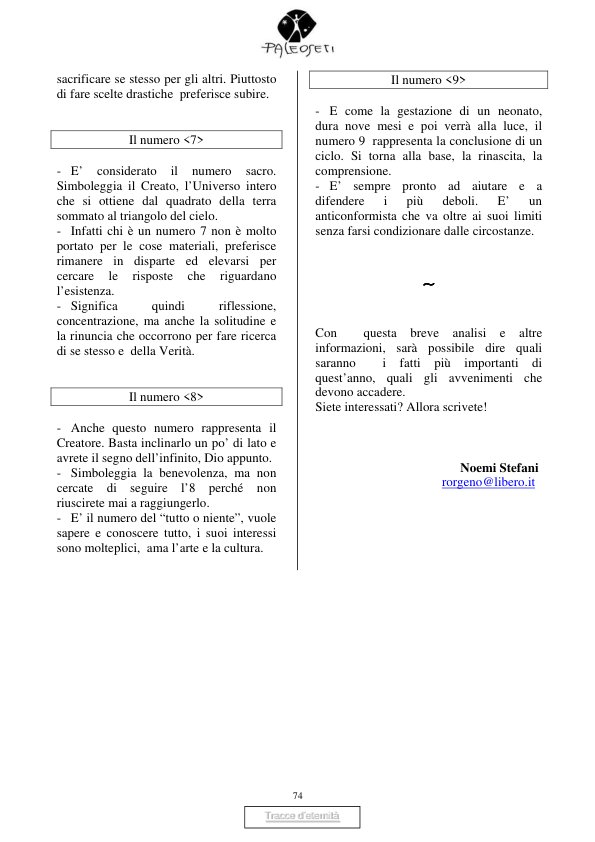

In [ ]:
print(train_ds[0]["specific_detail_query"])
display(train_ds[0]["image"])

From this dataset we will have the following columns to create the documents and the queries:

- `image` contains our documents.
- `specific_detail_query` contains the textual queries.

In [ ]:
def collate_fn(examples):
  texts = []
  images = []

  for example in examples:

    texts.append(example["specific_detail_query"])
    images.append(example["image"].convert("RGB"))

  batch_images = processor(images=images, return_tensors="pt").to(model.device)
  batch_queries = processor(text=texts, return_tensors="pt").to(model.device)
  return (batch_queries, batch_images)

## Trainer

The trainer uses a ColBERT contrastive hard-margin loss. This loss is implemented in ColPali engine, it expects batch document and query embeddings, so essentially we need to process the documents and queries separately, then pass them to the model separately, then send to loss calculation.

Note that, since we are defining a custom loss, we have to subclass transformers Trainer to be able to pass it to the model.

In [ ]:
import torch
from transformers import Trainer


class ContrastiveTrainer(Trainer):
    def __init__(self, loss_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_func = loss_func

    def compute_loss(self, model, inputs, num_items_in_batch=4, return_outputs=False):
        query_inputs, doc_inputs = inputs
        query_outputs = model(**query_inputs)
        doc_outputs = model(**doc_inputs)
        loss = self.loss_func(query_outputs.embeddings, doc_outputs.embeddings)
        return (loss, (query_outputs, doc_outputs)) if return_outputs else loss

    def prediction_step(self, model, inputs):
        query_inputs, doc_inputs = inputs # unpack from data collator
        with torch.no_grad():
            query_outputs = model(**query_inputs)
            doc_outputs = model(**doc_inputs)

            loss = self.loss_func(query_outputs.embeddings, doc_outputs.embeddings)
            return loss, None, None

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./colpali_ufo",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    logging_steps=20,
    warmup_steps=100,
    learning_rate=5e-5,
    save_total_limit=1,
    report_to="tensorboard",
    dataloader_pin_memory=False
)

In [ ]:
from colpali_engine.loss import ColbertPairwiseCELoss

trainer = ContrastiveTrainer(
    model=model,
    train_dataset=train_ds,
    args=training_args,
    loss_func=ColbertPairwiseCELoss(),
    data_collator=collate_fn
)

trainer.args.remove_unused_columns = False


We are training on a small dataset (little less than 2k examples) for one epoch so the training should be fairly short (around 8 mins). The peak GPU memory is around 32 GB.

In [ ]:
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
20,0.142100
40,0.114500
60,0.103400
80,0.096000
100,0.106300
120,0.120000


TrainOutput(global_step=122, training_loss=0.11237441638454063, metrics={'train_runtime': 484.0742, 'train_samples_per_second': 4.037, 'train_steps_per_second': 0.252, 'total_flos': 0.0, 'train_loss': 0.11237441638454063, 'epoch': 0.9979550102249489})

## Load and test fine-tuned model

Let's try the fine-tuned model. You can simply test by passing in text-image pairs and check the scores for the ones that are actually pairs of each other, and also the scores of those that are irrelevant (i.e. all scores except for the scores of the matching ones).

Skandinavisk UFO Information


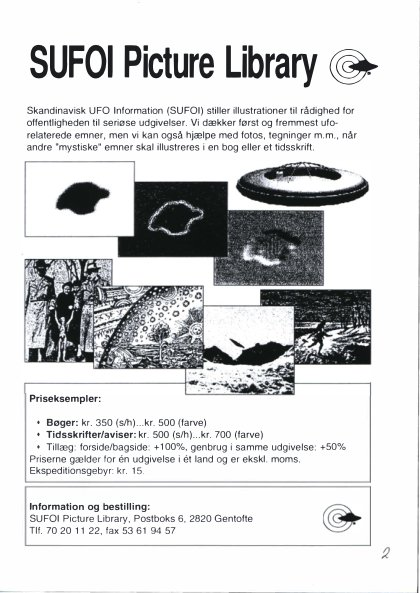

Large black cat sighting


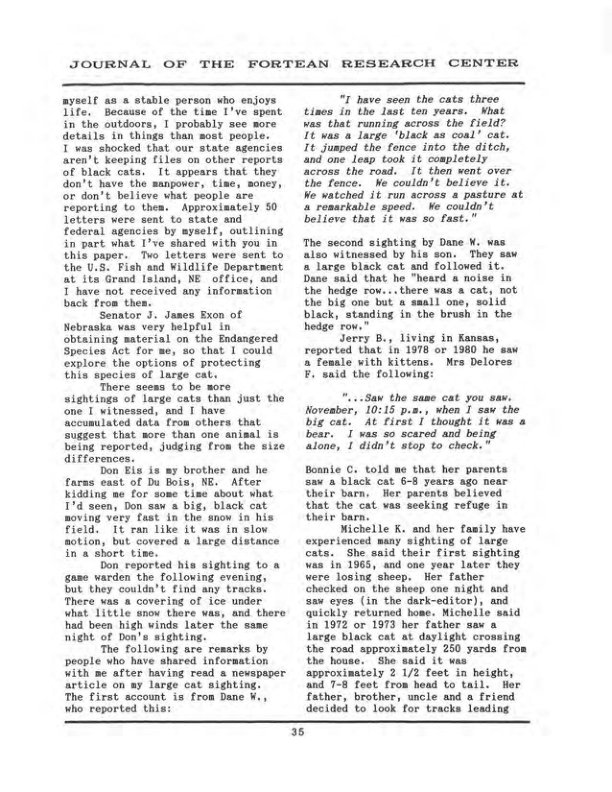

23 March 1999, Mexico - between 18:15 and 18:30 h Ortszeit


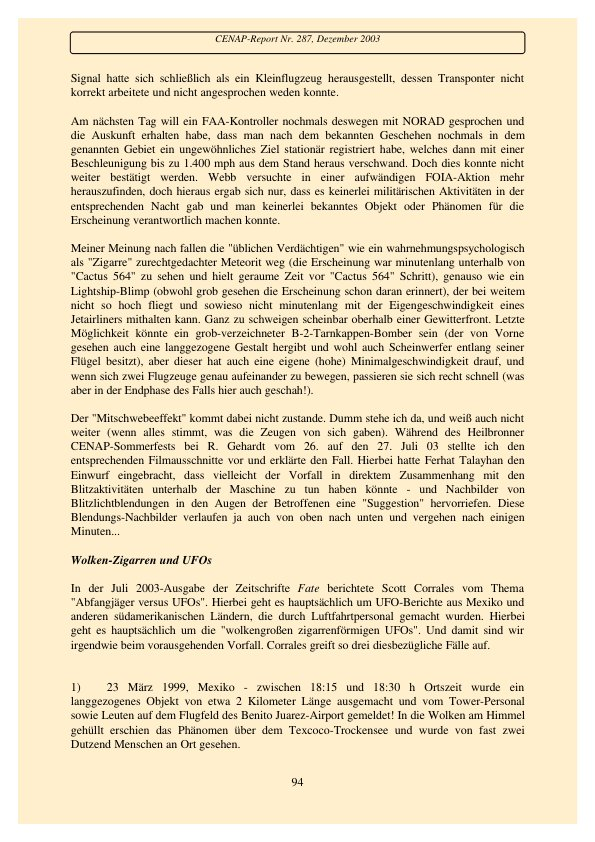

In [ ]:
print(test_ds[0]["specific_detail_query"])
display(test_ds[0]["image"])
print(test_ds[1]["specific_detail_query"])
display(test_ds[1]["image"])
print(test_ds[2]["specific_detail_query"])
display(test_ds[2]["image"])

In [ ]:
images = [test_ds[0]["image"], test_ds[1]["image"], test_ds[2]["image"]]
texts = [test_ds[0]["specific_detail_query"], test_ds[1]["specific_detail_query"], test_ds[2]["specific_detail_query"]]

# process
batch_images = processor(images=images).to(model.device)
batch_queries = processor(text=texts).to(model.device)

# infer
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings

# Score the queries against the images
scores = processor.score_retrieval(query_embeddings, image_embeddings)

The matching text-image scores are on the diagon of the scores below, as you can see, they're matched correctly!

In [ ]:
scores

tensor([[13.0000,  7.2812,  8.0625],
        [ 7.0625, 12.5625,  7.0938],
        [12.3750, 14.5000, 16.5000]], dtype=torch.bfloat16)

I will push the model to the Hub for your convenience to try it out.

In [ ]:
trainer.push_to_hub("merve/colpali-ft")